In [1]:
import matplotlib.pyplot as plt
from teyssier.sedov import sedovana
from superfv.euler_solver import EulerSolver
from superfv.initial_conditions import sedov
from superfv.visualization import plot_1d_slice

In [2]:
gamma = 1.4
N = 100
T = 0.8

In [3]:
def f_sedov(idx, x, y, z, t, xp):
    return sedov(
        idx,
        x,
        y,
        z,
        t,
        xp=xp,
        h=1 / N,
        gamma=gamma,
        P0=1e-5,
        rho0=1.0,
    )


sim0 = EulerSolver(
    ic=f_sedov,
    bcx=("reflective", "free"),
    riemann_solver="hllc",
    gamma=gamma,
    nx=N,
    p=0,
)

sim1 = EulerSolver(
    ic=f_sedov,
    bcx=("reflective", "free"),
    riemann_solver="hllc",
    gamma=gamma,
    nx=N,
    p=1,
    MUSCL=True,
    MUSCL_limiter="moncen",
    flux_recipe=2,
)

simzs = EulerSolver(
    ic=f_sedov,
    bcx=("reflective", "free"),
    riemann_solver="hllc",
    gamma=gamma,
    nx=N,
    p=3,
    flux_recipe=2,
    ZS=True,
    PAD={"rho": (0.0, None), "P": (0.0, None)},
    # SED=True,
)

simmood = EulerSolver(
    ic=f_sedov,
    bcx=("reflective", "free"),
    riemann_solver="hllc",
    gamma=gamma,
    nx=N,
    p=3,
    flux_recipe=2,
    MOOD=True,
    cascade="muscl1",
    max_MOOD_iters=2,
    NAD=True,
    NAD_rtol=1e-2,
    NAD_atol=1e-7,
    PAD={"rho": (0.0, None), "P": (0.0, None)},
    SED=True,
)

In [4]:
sim0.euler(T)
sim1.musclhancock(T)
simzs.ssprk3(T)
simmood.ssprk3(T)

Step #306 @ t=8.00e-01 | dt=2.91e-03 | min(rho)=2.99e-02, min(P)=1.00e-05 | (done)                  
Step #307 @ t=8.00e-01 | dt=1.21e-03 | min(rho)=3.09e-02, min(P)=1.00e-05 | (done)                  
Step #313 @ t=8.00e-01 | dt=9.20e-04 | min(rho)=3.14e-02, min(P)=-1.14e-03 | (done)                 
Step #318 @ t=8.00e-01 | dt=1.81e-03 | min(rho)=2.84e-02, min(P)=-9.47e-04 | (done)                 


In [5]:
dim = 1
E0 = 1
rho0 = 1

r, d, u, P = sedovana(gamma, dim)

r *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (2 / (dim + 2))
d *= rho0
u *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (-dim / (dim + 2))
P *= (E0 / rho0) ** (2.0 / (dim + 2)) * T ** (-2 * dim / (dim + 2)) * rho0

chi0=np.float64(0.97306051566207)


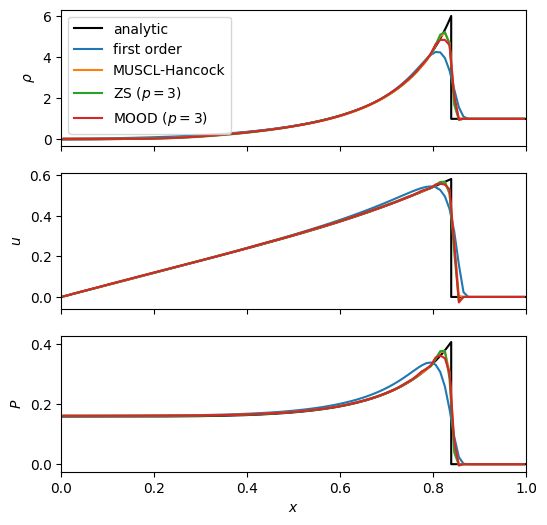

In [6]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$u$")
axs[2].set_ylabel(r"$P$")

style = dict()

axs[0].plot(r, d, color="k", label="analytic")
plot_1d_slice(sim0, axs[0], "rho", **style, label="first order")
plot_1d_slice(sim1, axs[0], "rho", **style, label="MUSCL-Hancock")
plot_1d_slice(simzs, axs[0], "rho", **style, label=rf"ZS $(p={simzs.p})$")
plot_1d_slice(simmood, axs[0], "rho", **style, label=rf"MOOD $(p={simmood.p})$")

axs[1].plot(r, u, label="analytic", color="k")
plot_1d_slice(sim0, axs[1], "vx", **style)
plot_1d_slice(sim1, axs[1], "vx", **style)
plot_1d_slice(simzs, axs[1], "vx", **style)
plot_1d_slice(simmood, axs[1], "vx", **style)

axs[2].plot(r, P, label="analytic", color="k")
plot_1d_slice(sim0, axs[2], "P", **style, xlabel=True)
plot_1d_slice(sim1, axs[2], "P", **style)
plot_1d_slice(simzs, axs[2], "P", **style)
plot_1d_slice(simmood, axs[2], "P", **style)

axs[0].set_xlim(0, 1)
axs[0].legend()

In [7]:
sim0.print_timings()

Routine                      # of calls  Total time (s) % time
---------------------------  ----------  --------------  ------
wall                                  1            0.26   100.0
take_step                           306            0.24    93.4
compute_dt                          306            0.03     9.8
apply_bc                            308            0.01     3.6
riemann_solver                      306            0.11    40.7
zhang_shu_limiter                     0               -       -
MOOD_loop                             0               -       -
      detect_troubled_cells           0               -       -
      revise_fluxes                   0               -       -
snapshot                              2            0.00     1.3
minisnapshot                        307            0.01     4.1


In [8]:
sim1.print_timings()

Routine                      # of calls  Total time (s) % time
---------------------------  ----------  --------------  ------
wall                                  1            0.29   100.0
take_step                           307            0.27    93.3
compute_dt                          307            0.02     8.3
apply_bc                            309            0.01     3.0
riemann_solver                      307            0.10    35.3
zhang_shu_limiter                     0               -       -
MOOD_loop                             0               -       -
      detect_troubled_cells           0               -       -
      revise_fluxes                   0               -       -
snapshot                              2            0.01     2.4
minisnapshot                        308            0.01     3.4


In [9]:
simzs.print_timings()

Routine                      # of calls  Total time (s) % time
---------------------------  ----------  --------------  ------
wall                                  1            1.05   100.0
take_step                           313            1.02    97.1
compute_dt                          313            0.03     2.5
apply_bc                            947            0.03     2.9
riemann_solver                      945            0.33    31.4
zhang_shu_limiter                   945            0.23    21.7
MOOD_loop                             0               -       -
      detect_troubled_cells           0               -       -
      revise_fluxes                   0               -       -
snapshot                              2            0.02     1.5
minisnapshot                        314            0.01     1.1


In [10]:
simmood.print_timings()

Routine                      # of calls  Total time (s) % time
---------------------------  ----------  --------------  ------
wall                                  1            2.83   100.0
take_step                           318            2.82    99.3
compute_dt                          318            0.03     1.0
apply_bc                           2864            0.10     3.7
riemann_solver                     2727            0.97    34.4
zhang_shu_limiter                     0               -       -
MOOD_loop                           954            2.01    70.9
      detect_troubled_cells        1908            0.87    30.7
      revise_fluxes                1798            1.12    39.6
snapshot                              2            0.00     0.0
minisnapshot                        319            0.01     0.5
